## Notebook Objectives


In this notebook we are going to implement and train a neural network from scratch

In [ ]:
import numpy as np

## Layers

### Abstract Layer Class

The Layer class serves as an abstract base class for all layers in the network. It includes placeholder methods:

-forward: The forward pass computes the output of the layer given an input.
-backward: The backward pass computes the gradients with respect to the input and parameters.
-step: Updates the layer parameters (weights and biases).

In [ ]:
class Layer:
    def __init__(self):
        self.inp = None
        self.out = None

    def __call__(self, inp: np.ndarray) -> np.ndarray:
        return self.forward(inp)

    def forward(self, inp: np.ndarray) -> np.ndarray:
        raise NotImplementedError

    def backward(self, up_grad: np.ndarray) -> np.ndarray:
        raise NotImplementedError

    def step(self, lr: float) -> None:
        pass

## Linear Layers

The Linear class implements the fully connected (or dense) layer of a neural network, which performs a linear transformation on the input:

$$\mathbf{y} = \mathbf{x} \cdot \mathbf{W} + \mathbf{b}$$

**Initialization**
- `self.w`: Represents the weight matrix of shape `(in_dim, out_dim)`, initialized using small random values.
- `self.b`: Bias vector of shape `(1, out_dim)`, initialized to zeros.
- `self.dw` and `self.db`: These store the computed gradients of weights and biases during backpropagation.




**Forward Pass**
- The forward pass computes:
$$\mathbf{out} = \mathbf{inp} \cdot \mathbf{W} + \mathbf{b}$$
where:
  - `inp`: Input matrix of shape `(batch_size, in_dim)`
  - `self.w`: Weight matrix of shape `(in_dim, out_dim)`
  -	`self.b`: Bias matrix of shape `(1, out_dim)`
-	The result is a matrix out of shape `(batch_size, out_dim)`.




**Backward Pass**
- The backward pass computes gradients needed for updating the weights and biases. Given the upstream gradient `up_grad` (from the loss with respect to the output of this layer), we calculate:
  - Gradient w.r.t. weights (`self.dw`):
    $$\frac{\partial L}{\partial W} = \mathbf{inp}^T\cdot\text{up\_grad}$$
  - Gradient w.r.t. biases (`self.db`):
    $$\frac{\partial L}{\partial b} = \sum \text{up\_grad} \text{ (summed across batch)}$$
  - Gradient to propagate to the previous layer (`down_grad`):
    $$\text{down\_grad} = \text{up\_grad} \cdot W^T$$
- This allows the gradient to flow backward to earlier layers.




**Step Method**
- Updates the weights and biases using the computed gradients and learning rate (`lr`):
    $$W = W - lr \cdot \frac{\partial L}{\partial W}$$
    $$b = b - lr \cdot \frac{\partial L}{\partial b}$$

In [ ]:
class Linear(Layer) :
    def __init__(self, in_dim, out_dim) :
        #Xiavier initialization
        limit = np.sqrt(1/(in_dim + out_dim))
        self.w = np.random.uniform(-limit, limit, size=(in_dim, out_dim))
        self.b = np.zeros((1,out_dim))
        self.dw = np.zeros_like(self.w)
        self.db = np.zeros_like(self.b)

    def forward(self, inp:np.ndarray) -> np.ndarray :
        """Perform the linear transformation: output = inp * W + b"""
        self.inp = inp
        return np.dot(inp, self.w) + self.b

    def backward(self, up_grade:np.ndarray)-> np.ndarray :
        self.dw = np.dot(self.inp.T, up_grade)
        self.db = np.sum(up_grade, axis=0, keepdims = True)
        return np.dot(up_grade,self.w.T)

    def step(self, lr:float) -> None :
        self.w -= self.dw * lr
        self.b -= self.db * lr

## Activation Function

We can implement activation functions as layers. This will simplify the training process

### Sigmoid

- The Sigmoid function is defined as follows:

$$f(x) = \frac{1}{1 + e^{-x}}$$

- Sigmoid squashes the input into the range [0, 1], making it useful for binary classification tasks.
- It converts any real-valued number into a probability-like output.
- However, in deeper networks, it may cause vanishing gradients due to its flat slope for extreme values.
- The derivative of Sigmoid is convenient to compute using its output  $f(x)$:
$$f'(x) = \frac{-e^{-x}}{(1 + e^{-x})^2} = \frac{1}{1 + e^{-x}} \cdot \frac{e^{-x}}{1 + e^{-x}} = f(x) \cdot (1-f(x))$$

In [ ]:
class Sigmoid(Layer) :
    def forward(self, inp:np.ndarray) -> np.ndarray :

        self.out = 1 / (1 + np.exp(-inp))
        return self.out
    def backward(self, up_grad : np.ndarray) -> np.ndarray :
        return  self.out *(1-self.out) * up_grad

In [ ]:
class Relu(Layer) :
    def forward(self, inp) :
        self.inp = inp
        out = np.maximum(0, inp) # maximum performs element-wise maximum
        return out
    def backward(self, up_grad) :
        return up_grad * (self.inp > 0)


## Loss Function

### Abstract Loss Class

The `Loss` class serves as an abstract base class for all layers in the network. It includes placeholder methods:
- `forward`: To compute the loss given predictions and targets.
- `backward`: To compute the loss given predictions and targets.

In [ ]:
class Loss:
    def __init__(self):
        self.prediction = None
        self.target = None
        self.loss = None

    def __call__(self, prediction: np.ndarray, target: np.ndarray) -> float:
        return self.forward(prediction, target)

    def forward(self, prediction: np.ndarray, target: np.ndarray) -> float:
        raise NotImplementedError

    def backward(self) -> np.ndarray:
        raise NotImplementedError

## Mean Squared Error (MSE) Loss

MSE is used primarily for regression tasks, where you need to measure the distance between the predicted continuous values and the true values:

$$L = \frac{1}{N} \sum_{i} (p_i - y_i)^2$$

where $p_i$ is the predicted value, $y_i$ is the true value (target) and $N$ is the batch size.

The gradient measures the difference between the prediction and the target, scaled by the batch size:

$$\frac{\partial L}{\partial p_i} = \frac{2}{N} (p_i - y_i)$$

In [ ]:
class MSE(Loss) :
    def forward(self, prediction, target) :
        self.prediction = prediction
        self.target = target
        self.loss = np.mean((prediction-target)**2)
        return self.loss
    def backward(self) :
        return 2 * (self.prediction-self.target) / len(self.prediction)

## Neural Network

Now we can combine everything we've done earlier to build a neural network class called `MLP` with the following methods:

- `forward`: Sequentially passes input through each layer in the network to compute the output.
- `loss`: Computes the loss between the predicted output and the true target using the specified loss function.
- `backward`: Propagates the gradient from the loss function through each layer, updating the gradients of the parameters in each layer.
- `update`: Updates each layer's parameters (e.g., weights and biases) using the gradients computed during backpropagation.
- `train`: Executes the training loop for a specified number of epochs, iterating over the dataset in mini-batches, performing the forward pass, computing the loss, backpropagating the gradients, and updating the parameters.

In [ ]:
class MLP :
    def __init__ (self, layers:list[Layer], loss_fun:Loss, lr:float) -> None :
        """
        Multi-Layer Perceptron (MLP) class.
        Arguments:
        - layers: List of layers (e.g., Linear, ReLU, etc.).
        - loss_fn: Loss function object (e.g., CrossEntropy, MSE).
        - lr: Learning rate.
        """
        self.layers = layers
        self.loss_fun = loss_fun
        self.lr = lr

    def __call__(self, inp) :
        self.forward(inp)

    def forward(self, inp) :
        for layer in self.layers :
          inp = layer.forward(inp)
        return inp

    def loss(self, prediction, target) :
        return self.loss_fun(prediction, target)

    def backward(self) :
        up_grad = self.loss_fun.backward()
        for layer in reversed(self.layers) :
            up_grad = layer.backward(up_grad)

    def update(self) :
        for layer in self.layers :
          layer.step(self.lr)

    def train(self, x_train, y_train, x_val, y_val, epochs, batch_size):
        """Train the MLP over the given dataset for a number of epochs."""
        losses = np.empty(epochs)

        for epoch in range(epochs) :
          running_loss = 0
          for i in range(0, len(x_train), batch_size) :
            x_batch = x_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]

            prediction = self.forward(x_batch)
            running_loss += self.loss(prediction, y_batch) * batch_size
            self.backward()
            self.update()
          losses[epoch] = running_loss / len(x_train)
        return losses




## Regression training

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np

# Load California Housing dataset
california = fetch_california_housing()
X = california.data
y = california.target.reshape(-1, 1)

                              # Normalize features and targets
scaler_X = StandardScaler() # a preprocessing tool from scikit-learn that standardizes features by removing the mean and scaling to unit variance.
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42
)


In [ ]:
#define layers
layers = [
    Linear(X_train.shape[1], 50),
    Relu(),
    Linear(50, 1)
]
#define model
model = MLP(layers, MSE(), lr=0.001)
losses = model.train(X_train,y_train,X_test,y_test,500, 64)
#train_model



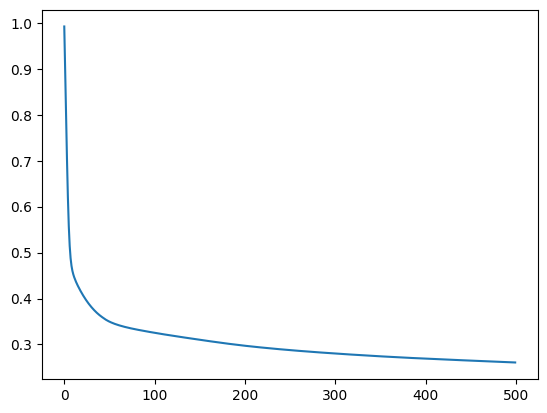

In [ ]:
from matplotlib import pyplot as plt
#plot losses
plt.plot(losses)

#plot train and validation loss